In [1]:
!pip install tensorflow keras opencv-python numpy scikit-learn pillow rembg django djangorestframework


In [5]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2


In [6]:
!pip install tensorflow-cpu  # Optimized for CPU


  Using cached tensorflow_cpu-2.16.2-cp312-cp312-macosx_10_15_x86_64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 MB 944.8 kB/s eta 0:00:0000:010:07m


In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
import os
import numpy as np
from PIL import Image
from rembg import remove
from sklearn.model_selection import train_test_split

# Define data directory and image size
data_dir = '/users/gorantlasaitejaswini/Desktop/mlplastic'
img_size = (224, 224)

# Get list of class names, ignoring non-directory files
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

X, y, weights = [], [], []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    
    # Ensure it's a directory before proceeding
    if not os.path.isdir(class_path):
        continue
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Skip hidden/system files like .DS_Store
        if img_name.startswith('.'):
            continue
        
        try:
            # Load image
            img = Image.open(img_path).convert('RGBA')
            img_no_bg = remove(img)  # Remove background
            img_no_bg = img_no_bg.convert('RGB')
            img_no_bg = img_no_bg.resize(img_size)
            img_array = np.array(img_no_bg) / 255.0  # Normalize
            
            # Extract weight from filename (assuming weight is in filename like 'plastic_100g.jpg')
            weight = int(''.join(filter(str.isdigit, img_name)))
            
            X.append(img_array)
            y.append(class_idx)
            weights.append(weight)
        
        except Exception as e:
            print(f"Skipping {img_name}: {e}")  # Print error but continue processing

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)
weights = np.array(weights)

# Train-Test Split
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 176, Test samples: 44


In [21]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)

# Output layers
classification_output = keras.layers.Dense(len(classes), activation='softmax', name='class_output')(x)
weight_output = keras.layers.Dense(1, activation='linear', name='weight_output')(x)

# Final Model
model = keras.Model(inputs=inputs, outputs=[classification_output, weight_output])
model.compile(optimizer='adam',
              loss=['sparse_categorical_crossentropy', 'mse'],  # Loss for each output
              metrics=[['accuracy'], ['mae']])  # Metric for each output


In [22]:
history = model.fit(X_train, [y_train, weights_train], epochs=10, validation_data=(X_test, [y_test, weights_test]))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 801ms/step - class_output_accuracy: 0.1823 - class_output_loss: 3.1563 - loss: 635.7602 - weight_output_loss: 629.6469 - weight_output_mae: 20.5220 - val_class_output_accuracy: 0.1364 - val_class_output_loss: 2.1240 - val_loss: 404.2490 - val_weight_output_loss: 494.6513 - val_weight_output_mae: 16.3031
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - class_output_accuracy: 0.1692 - class_output_loss: 2.6537 - loss: 356.7786 - weight_output_loss: 352.5097 - weight_output_mae: 15.2688 - val_class_output_accuracy: 0.1364 - val_class_output_loss: 4.6588 - val_loss: 230.6792 - val_weight_output_loss: 276.4490 - val_weight_output_mae: 12.2664
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - class_output_accuracy: 0.1409 - class_output_loss: 5.4522 - loss: 180.9998 - weight_output_loss: 175.8491 - weight_output_mae: 10.4455 - val_class_output_accuracy: 0.1591 - val_class_output_loss: 7.4397 - val_loss: 218.5619 - val_weight_output_loss: 205.3380 -

In [23]:
model.save('plastic_model.keras') 

In [3]:
import numpy as np
from PIL import Image
from rembg import remove
import keras

# Load trained model
model = keras.models.load_model('plastic_model.keras')

# Define expected image size and class labels (Ensure order matches model training)
img_size = (224, 224)  
classes = ['hdpe', 'ldpe', 'others', 'pet', 'pp', 'ps', 'pvc']  

def predict_plastic(img_path):
    try:
        print("Opening image...")
        img = Image.open(img_path).convert('RGBA')

        print("Removing background...")
        img_no_bg = remove(img).convert('RGB')

        print("Resizing image...")
        img_no_bg = img_no_bg.resize(img_size)  

        print("Converting to NumPy array...")
        img_array = np.array(img_no_bg, dtype=np.float32) / 255.0  

        print("Expanding dimensions for model input...")
        img_array = np.expand_dims(img_array, axis=0)  

        print("Image shape after processing:", img_array.shape)

        # Debugging: Check pixel values
        print("First pixel values:", img_array[0, 0, 0, :])

        print("Making prediction...")
        outputs = model.predict(img_array)
        print("Raw model output:", outputs)

        if isinstance(outputs, list) and len(outputs) == 2:
            class_pred, weight_pred = outputs
        else:
            print("Unexpected output shape from model:", outputs)
            return None, None

        # Debugging: Check class probabilities
        print("Class Probabilities:", class_pred)
        print("Predicted Class Index:", np.argmax(class_pred))

        predicted_class = classes[np.argmax(class_pred)]
        predicted_weight = float(weight_pred[0][0])  

        return predicted_class, predicted_weight
    
    except Exception as e:
        print("Error during prediction:", str(e))
        return None, None

# Test prediction
img_path = '/users/gorantlasaitejaswini/Desktop/test/img7.png'
pred_class, pred_weight = predict_plastic(img_path)
if pred_class is not None:
    print(f"Predicted Class: {pred_class}, Predicted Weight: {pred_weight}g")


Opening image...
Removing background...
Resizing image...
Converting to NumPy array...
Expanding dimensions for model input...
Image shape after processing: (1, 224, 224, 3)
First pixel values: [0. 0. 0.]
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Raw model output: [array([[0.05811368, 0.25782046, 0.06790409, 0.38350868, 0.01859731,
        0.21037486, 0.00368105]], dtype=float32), array([[15.762171]], dtype=float32)]
Class Probabilities: [[0.05811368 0.25782046 0.06790409 0.38350868 0.01859731 0.21037486
  0.00368105]]
Predicted Class Index: 3
Predicted Class: pet, Predicted Weight: 15.762170791625977g


In [27]:
import os
print(os.path.exists(img_path))  # Should print True if the file exists


True


In [28]:
from rembg import remove

img = Image.open(img_path).convert('RGBA')
img_no_bg = remove(img).convert('RGB')
img_no_bg.show()  # Show the image to confirm background removal


In [29]:
print("Image shape before expansion:", img_no_bg.size)
print("Image array shape after processing:", img_array.shape)


Image shape before expansion: (224, 224)
Image array shape after processing: (224, 224, 3)


In [5]:
import tensorflow as tf
import os
from collections import Counter

# Define dataset path
dataset_path = "/users/gorantlasaitejaswini/Desktop/mlplastic"

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32
)

# Extract class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Count images per class
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print("Class Distribution:", class_counts)


Found 219 files belonging to 7 classes.
Class Names: ['hdpe', 'ldpe', 'others', 'pet', 'pp', 'ps', 'pvc']
Class Distribution: {'hdpe': 46, 'ldpe': 32, 'others': 19, 'pet': 38, 'pp': 35, 'ps': 12, 'pvc': 37}


2025-03-23 12:13:10.462931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(range(len(class_names))),
    y=np.concatenate([labels.numpy() for _, labels in train_ds])
)

# Convert to dictionary
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 0.6801242236024845, 1: 0.9776785714285714, 2: 1.6466165413533835, 3: 0.8233082706766918, 4: 0.8938775510204081, 5: 2.607142857142857, 6: 0.8455598455598455}


2025-03-23 12:13:43.033221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
import tensorflow as tf

dataset_path = "/users/gorantlasaitejaswini/Desktop/mlplastic"

# Load dataset properly
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True  # Ensures dataset isn't exhausted early
)

# Apply prefetching to prevent OUT_OF_RANGE
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 219 files belonging to 7 classes.


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert dataset to list (to split manually)
dataset_list = list(train_ds.as_numpy_iterator())

# Extract images (X) and labels (y)
X, y = zip(*dataset_list)
X = np.concatenate(X, axis=0)  # Stack all images
y = np.concatenate(y, axis=0)  # Stack all labels

# Split into training (80%), validation (10%), testing (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Convert back to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

print("Dataset Split: ✅")
print(f"Training: {len(X_train)} samples, Validation: {len(X_val)} samples, Testing: {len(X_test)} samples")


2025-03-23 12:14:44.752004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Dataset Split: ✅
Training: 175 samples, Validation: 22 samples, Testing: 22 samples


In [9]:
from tensorflow.keras import layers, models

# Define Model
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze pretrained layers

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output 1: Classification (Plastic Type)
    class_output = layers.Dense(7, activation='softmax', name="class_output")(x)

    # Output 2: Regression (Weight)
    weight_output = layers.Dense(1, activation='linear', name="weight_output")(x)

    # Build model
    model = models.Model(inputs=inputs, outputs=[class_output, weight_output])

    return model

model = create_model()
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 7)         │        903 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weight_output       │ (None, 1)         │        129 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "class_output": "sparse_categorical_crossentropy",
        "weight_output": "mse"
    },
    metrics={
        "class_output": "accuracy",
        "weight_output": "mae"
    }
)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights_dict  # Apply class balancing
)


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 961ms/step - class_output_accuracy: 0.1555 - loss: 2.4124 - val_class_output_accuracy: 0.2273 - val_loss: 1.8809
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - class_output_accuracy: 0.2577 - loss: 1.7488 - val_class_output_accuracy: 0.2273 - val_loss: 1.8494
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 637ms/step - class_output_accuracy: 0.3481 - loss: 1.4253 - val_class_output_accuracy: 0.1364 - val_loss: 1.8131
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 642ms/step - class_output_accuracy: 0.5271 - loss: 1.2655 - val_class_output_accuracy: 0.3636 - val_loss: 1.7315
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - class_output_accuracy: 0.4998 - loss: 1.2466 - val_class_output_accuracy: 0.4091 - val_loss: 1.7351
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - class_output_accuracy: 0.6703 - loss: 0.9775 - val_class_output_accuracy: 0.3636 - val_loss: 1.7354
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - class_output_accuracy: 0.6518 - loss: 0.9094 -

In [11]:
results = model.evaluate(test_ds)
print("Test Results:", results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - class_output_accuracy: 0.1364 - loss: 2.4358
Test Results: [2.4358224868774414, 0.13636364042758942]


In [12]:
model.save("plastic_model.keras")


In [19]:
import numpy as np
from PIL import Image
from rembg import remove

# Load trained model
model = tf.keras.models.load_model('plastic_model.keras')

def predict_plastic(img_path):
    try:
        img = Image.open(img_path).convert('RGBA')

        # Remove background
        img_no_bg = remove(img).convert('RGB')
        img_no_bg = img_no_bg.resize((224, 224))

        # Convert to array
        img_array = np.array(img_no_bg, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  

        # Predict
        outputs = model.predict(img_array)
        class_pred, weight_pred = outputs

        predicted_class = classes[np.argmax(class_pred)]
        predicted_weight = float(weight_pred[0][0])  

        return predicted_class, predicted_weight
    
    except Exception as e:
        print("Error:", str(e))
        return None, None

# Test image
img_path = "/users/gorantlasaitejaswini/Desktop/test/img7.png"
pred_class, pred_weight = predict_plastic(img_path)
print(f"Predicted Class: {pred_class}, Predicted Weight: {pred_weight}g")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: pvc, Predicted Weight: 2.5335235595703125g


In [20]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights_dict  # Apply computed class weights
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 998ms/step - class_output_accuracy: 0.9720 - loss: 0.2127 - val_class_output_accuracy: 0.5455 - val_loss: 1.7083
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - class_output_accuracy: 0.9645 - loss: 0.2443 - val_class_output_accuracy: 0.5000 - val_loss: 1.6886
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - class_output_accuracy: 0.9751 - loss: 0.1829 - val_class_output_accuracy: 0.5000 - val_loss: 1.6865
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - class_output_accuracy: 0.9777 - loss: 0.1687 - val_class_output_accuracy: 0.4545 - val_loss: 1.7202
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - class_output_accuracy: 0.9717 - loss: 0.1680 - val_class_output_accuracy: 0.5000 - val_loss: 1.7361
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 618ms/step - class_output_accuracy: 0.9927 - loss: 0.1469 - val_class_output_accuracy: 0.5455 - val_loss: 1.7785
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 629ms/step - class_output_accuracy: 0.9938 - los

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2)
])


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Pre-trained Model (MobileNetV2)
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # We will add our own classifier
    weights="imagenet"  # Use pre-trained ImageNet weights
)

# Freeze base model layers
base_model.trainable = False

# Define Input Layer
inputs = layers.Input(shape=(224, 224, 3))

# Apply Data Augmentation (if needed)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2)
])

x = data_augmentation(inputs)  # Apply augmentation
x = base_model(x, training=False)  # Use MobileNetV2 for feature extraction
x = layers.GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions

# Classification Head (Plastic Type)
class_output = layers.Dense(7, activation="softmax", name="class_output")(x)

# Regression Head (Plastic Weight Prediction)
x_weight = layers.Dense(16, activation="relu")(x)
weight_output = layers.Dense(1, activation="linear", name="weight_output")(x_weight)

# Define Model
model = keras.Model(inputs=inputs, outputs=[class_output, weight_output])

# Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss={
        "class_output": "sparse_categorical_crossentropy",
        "weight_output": "mse"
    },
    metrics={
        "class_output": "accuracy",
        "weight_output": "mae"
    }
)

# Print Model Summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ sequential_1[0][… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │     20,496 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 7)         │      8,967 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weight_output       │ (None, 1)         │         17 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,287,464 (8.73 MB)

 Trainable params: 29,480 (115.16 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
base_model.trainable = True  # Unfreeze the model
for layer in base_model.layers[:-20]:  # Keep first 20 layers frozen
    layer.trainable = False


In [25]:
weight_output = layers.Dense(16, activation='relu')(x)
weight_output = layers.Dense(1, activation='linear', name="weight_output")(weight_output)


In [26]:
import tensorflow as tf

dataset_path = "/users/gorantlasaitejaswini/Desktop/mlplastic"

# Load dataset and split into training (80%) and validation (20%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Optimize performance with prefetching
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 219 files belonging to 7 classes.
Using 176 files for training.
Found 219 files belonging to 7 classes.
Using 43 files for validation.


In [27]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20  # Adjust epochs as needed
)


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - class_output_accuracy: 0.2153 - loss: 2.0767 - val_class_output_accuracy: 0.2093 - val_loss: 4.1440
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 913ms/step - class_output_accuracy: 0.4878 - loss: 1.4629 - val_class_output_accuracy: 0.1860 - val_loss: 3.8798
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 925ms/step - class_output_accuracy: 0.5625 - loss: 1.2258 - val_class_output_accuracy: 0.0930 - val_loss: 8.1624
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 961ms/step - class_output_accuracy: 0.6697 - loss: 1.0676 - val_class_output_accuracy: 0.0930 - val_loss: 9.2704
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 908ms/step - class_output_accuracy: 0.7244 - loss: 0.8083 - val_class_output_accuracy: 0.1163 - val_loss: 7.6974
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 914ms/step - class_output_accuracy: 0.7413 - loss: 0.7376 - val_class_output_accuracy: 0.2093 - val_loss: 6.2498
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 916ms/step - class_output_accuracy: 0.7870 - loss: 0.5736 - va

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [30]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [31]:
from tensorflow.keras import layers, regularizers

inputs = layers.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)  
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.3)(x)  # Dropout layer

x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # More dropout
outputs = layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [32]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=30, 
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2328 - loss: 2.4149 - val_accuracy: 0.0930 - val_loss: 2.4181
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 908ms/step - accuracy: 0.2193 - loss: 2.3617 - val_accuracy: 0.0930 - val_loss: 2.4351
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 898ms/step - accuracy: 0.2158 - loss: 2.3330 - val_accuracy: 0.0930 - val_loss: 2.4603
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 882ms/step - accuracy: 0.2700 - loss: 2.3091 - val_accuracy: 0.0930 - val_loss: 2.4382
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2073 - loss: 2.2994 - val_accuracy: 0.0930 - val_loss: 2.3950
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2891 - loss: 2.2706 - val_accuracy: 0.0930 - val_loss: 2.3883
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2330 - loss: 2.2932 - val_accuracy: 0.0930 - val_loss: 2.3869
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 928ms/step - accuracy: 0.2444 - loss: 2.2601 - val_accuracy: 0.0930 - val_loss: 2.3974
Epoc

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [41]:
img_height = 224
img_width = 224


In [42]:
batch_size = 32  # Adjust based on your system's memory


In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/users/gorantlasaitejaswini/Desktop/mlplastic",  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)


Found 219 images belonging to 7 classes.


In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [50]:
test_generator = test_datagen.flow_from_directory(
    "/users/gorantlasaitejaswini/Desktop/mlplastic",  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    shuffle=False
)


Found 219 images belonging to 7 classes.


In [52]:
import tensorflow as tf
import numpy as np
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4572 - loss: 2.0670
Test Accuracy: 0.26


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set image dimensions
img_height, img_width = 224, 224  # Resized to match common architectures
batch_size = 32

# Data Augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/users/gorantlasaitejaswini/Desktop/mlplastic',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/users/gorantlasaitejaswini/Desktop/mlplastic',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Model Architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(7, activation='softmax')  # 7 classes
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[lr_reduction, early_stopping]
)

# Evaluate Model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/users/gorantlasaitejaswini/Desktop/mlplastic',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')


Found 178 images belonging to 7 classes.
Found 41 images belonging to 7 classes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.1733 - loss: 22.5547 - val_accuracy: 0.0976 - val_loss: 3.2547 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1392 - loss: 35.9856 - val_accuracy: 0.1707 - val_loss: 3.9116 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2267 - loss: 30.6676 - val_accuracy: 0.2439 - val_loss: 5.3278 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1925 - loss: 25.4912
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1915 - loss: 25.6689 - val_accuracy: 0.3171 - val_loss: 6.2003 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1982 - loss: 20.0559 - val_accuracy: 0.1707 - val_loss: 8.6144 - learning_rate: 2.0000e-04
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3137 - loss: 13.5136 - val_accuracy: 0.14

In [59]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    "/users/gorantlasaitejaswini/Desktop/mlplastic",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    "/users/gorantlasaitejaswini/Desktop/mlplastic",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    "/users/gorantlasaitejaswini/Desktop/mlplastic",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False
)


# Load MobileNetV2 as feature extractor
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model layers

# Define model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Train model
model.fit(train_generator, validation_data=valid_generator, epochs=EPOCHS, callbacks=callbacks)

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

Found 219 images belonging to 7 classes.
Found 219 images belonging to 7 classes.
Found 219 images belonging to 7 classes.
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1400 - loss: 3.5565 - val_accuracy: 0.1461 - val_loss: 2.1837 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1668 - loss: 2.9793 - val_accuracy: 0.1735 - val_loss: 2.0699 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1887 - loss: 2.8987 - val_accuracy: 0.2009 - val_loss: 1.9695 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1804 - loss: 2.6884 - val_accuracy: 0.2146 - val_loss: 1.8643 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2042 - loss: 2.7861 - val_accuracy: 0.2785 - val_loss: 1.7665 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2136 - loss: 2.5705 - val_accuracy: 0.3379 

In [60]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [61]:
for layer in base_model.layers[-20:]:  
    layer.trainable = True


In [62]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict on test data
Y_pred = model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# True labels
Y_true = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes))


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 760ms/step
Confusion Matrix:
 [[27  7  3  3  3  0  3]
 [ 1 24  0  2  2  0  3]
 [ 0  1 17  0  1  0  0]
 [ 1  0  0 32  0  1  4]
 [ 0  0  3  0 30  0  2]
 [ 1  0  0  1  0 10  0]
 [ 0  2  3  0  4  0 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.59      0.71        46
           1       0.71      0.75      0.73        32
           2       0.65      0.89      0.76        19
           3       0.84      0.84      0.84        38
           4       0.75      0.86      0.80        35
           5       0.91      0.83      0.87        12
           6       0.70      0.76      0.73        37

    accuracy                           0.77       219
   macro avg       0.78      0.79      0.78       219
weighted avg       0.78      0.77      0.77       219



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Class: others
Confidence Score: 31.80%


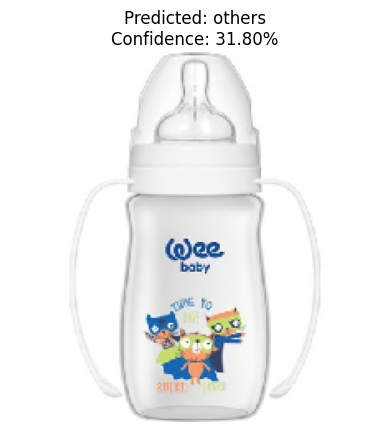

('others', 31.798484921455383)

In [80]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Get class labels from test_generator
class_labels = list(test_generator.class_indices.keys())  # Extract class names
threshold = 25  # Confidence threshold (%), adjust as needed

def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    
    # Make prediction
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100  # Get confidence percentage
    
    # If confidence is low, classify as "No Plastic Detected"
    if confidence < threshold:
        predicted_class = "No Plastic Detected"
    else:
        predicted_class = class_labels[class_index]  # Map index to class name

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Score: {confidence:.2f}%")
    
    # Display image with prediction & confidence
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.show()

    return predicted_class, confidence

# Test with an image
sample_image_path = "/users/gorantlasaitejaswini/Desktop/test/img1.jpg"  # Replace with actual image
predict_single_image(sample_image_path)


In [94]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)  # Feature extraction layer
x = Dense(64, activation="relu")(x)   # Additional dense layer

# Define `num_classes` from your dataset
num_classes = len(test_generator.class_indices)  # Total categories in dataset

# Classification Head (Predicts plastic type)
classification_output = Dense(num_classes, activation="softmax", name="class_output")(x)

# Regression Head (Predicts weight)
weight_output = Dense(1, activation="linear", name="weight_output")(x)

# Define Model with Two Outputs
model = Model(inputs=base_model.input, outputs=[classification_output, weight_output])
model.compile(optimizer="adam", 
              loss={"class_output": "categorical_crossentropy", "weight_output": "mse"}, 
              metrics={"class_output": "accuracy", "weight_output": "mae"})

model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,728 (9.27 MB)

 Trainable params: 2,396,616 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted Class: No Plastic Detected
Confidence Score: 22.94%
Estimated Weight: -0.40g


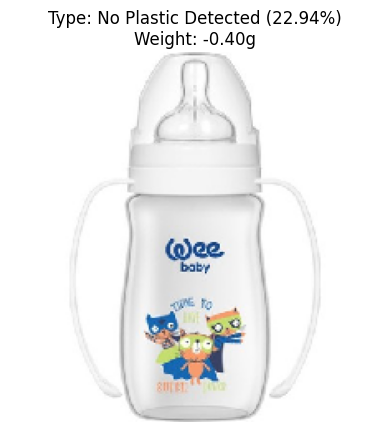

('No Plastic Detected', -0.4027709)

In [96]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Class labels from test_generator
class_labels = list(test_generator.class_indices.keys())  # Extract class names
threshold = 25  # Confidence threshold (%), adjust as needed

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Make prediction
    class_pred, weight_pred = model.predict(img_array)
    
    # Get class label
    class_index = np.argmax(class_pred, axis=1)[0]
    confidence = np.max(class_pred) * 100  # Get confidence percentage
    
    # If confidence is low, classify as "No Plastic Detected"
    predicted_class = "No Plastic Detected" if confidence < threshold else class_labels[class_index]

    # Extract weight (ensure it's a valid number)
    estimated_weight = weight_pred[0][0]  # Extract weight value
    
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Score: {confidence:.2f}%")
    print(f"Estimated Weight: {estimated_weight:.2f}g")

    # Display image with predictions
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Type: {predicted_class} ({confidence:.2f}%)\nWeight: {estimated_weight:.2f}g")
    plt.show()

    return predicted_class, estimated_weight

# Test with an image
sample_image_path = "/users/gorantlasaitejaswini/Desktop/test/img1.jpg"  # Replace with actual image
predict_image(sample_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


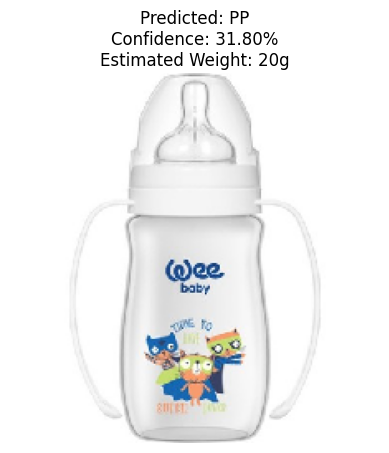

Final Prediction: PP
Confidence: 31.80%
Estimated Weight: 20g


In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("/users/gorantlasaitejaswini/Desktop/mlplastic/plastic_model.keras")
# Change path if needed

# Plastic weight dictionary (approximate values in grams)
plastic_weights = {
    "HDPE": 50,   # High-Density Polyethylene (e.g., detergent bottles, milk jugs)
    "PET": 30,    # Polyethylene Terephthalate (e.g., water bottles, soda bottles)
    "PP": 20,     # Polypropylene (e.g., food containers, bottle caps)
    "LDPE": 10,   # Low-Density Polyethylene (e.g., plastic bags, squeeze bottles)
    "PS": 15,     # Polystyrene (e.g., disposable cups, foam packaging)
    "PVC": 40,    # Polyvinyl Chloride (e.g., pipes, vinyl flooring)
    "others": 5,  # Miscellaneous plastics
    "No Plastic Detected": 0  # If no plastic is found
}


# Class names (ensure these match the model's output labels)
class_names = ["HDPE", "PET", "PP", "LDPE", "others","PS","PVC"]

# Function to preprocess the image
def preprocess_image(img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Function to make predictions
def predict_plastic(img_path):
    img, img_array = preprocess_image(img_path)

    # Get predictions
    Y_pred = model.predict(img_array)
    predicted_class_index = np.argmax(Y_pred, axis=1)[0]  # Get class index
    confidence_score = np.max(Y_pred) * 100  # Convert to percentage

    # Check confidence threshold (e.g., if confidence is low, say "No Plastic Detected")
    if confidence_score < 30:  # Adjust threshold as needed
        predicted_label = "No Plastic Detected"
        predicted_weight = 0
    else:
        predicted_label = class_names[predicted_class_index]
        predicted_weight = plastic_weights.get(predicted_label, 0)  # Get weight from dictionary

    # Display results
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2f}%\nEstimated Weight: {predicted_weight}g")
    plt.show()

    return predicted_label, confidence_score, predicted_weight

# Example usage
img_path = "/users/gorantlasaitejaswini/Desktop/test/img1.jpg"  # Change this to your test image
predicted_label, confidence, weight = predict_plastic(img_path)

print(f"Final Prediction: {predicted_label}")
print(f"Confidence: {confidence:.2f}%")
print(f"Estimated Weight: {weight}g")


In [83]:
import os
print(os.listdir())  # Lists all files in the current directory


['plastic-recogintion', '.zshrc.save', '.Rhistory', 'processed_thresh.jpg', '.config', 'Music', 'Cisco Packet Tracer 8.2.2', 'Untitled1.ipynb', '.DS_Store', 'book_review_project', '.zsh_profile.swp', '.CFUserTextEncoding', 'plastic_classifier.keras', 'Untitled.ipynb', '.zshrc', 'plastic-recognition', 'best_model.keras', '.packettracer', '.u2net', '.local', '.psql_history', 'Pictures', '.zprofile', '.nvm', 'python_stuff', '.zsh_history', 'Untitled2.ipynb', '.ipython', 'Desktop', 'event_management', 'Library', '.matplotlib', '.lesshst', 'gitdemo', 'processed_edges.jpg', 'captured_image.jpg', 'reaactapp', 'gitrepo', 'Public', '.idlerc', 'plastic.ipynb', 'background_subtracted.jpg', 'Movies', 'Applications', '.Rapp.history', '.Trash', 'plastic_model.h5', '.ipynb_checkpoints', '.jupyter', '.zcompdump', '.keras', '.npm', 'Documents', '.pyenv', 'plastic_classifier.h5', '.vscode', 'data', 'Downloads', '.python_history', 'plasticc.ipynb', '.cache', 'plastic_model.keras', '.gitconfig', '.bash_hi

In [88]:
ls -l /users/gorantlasaitejaswini/Desktop/mlplastic/plastic_model.h5


ls: /users/gorantlasaitejaswini/Desktop/mlplastic/plastic_model.h5: No such file or directory


In [90]:
model.save("/users/gorantlasaitejaswini/Desktop/mlplastic/plastic_model.keras")
